# Machine Learning - Project 2:
# _Unsteady parametrized Stokes equations in a 2D arterial bifurcation with stenosis: design of a Feed-Forward Autoencoder for data compression_

## Context

Our project aims at investigating the relationship between classical numerical methods and deep-learning techniques, with the final purpose of efficiently providing accurate solutions to parametrized PDE problems, being fully unaware of the values of the characteristic parameters. The professor's Deparis lab has developed efficient numerical methods for the resolution of parametrized time-dependent PDEs. In the following, we develop deep-learning models that take advantage of these numerical methods to solve parametrized unsteady PDEs without any knowledge of the characteristic parameters.

In this notebook, we make progress to this end by proposing deep-learning approaches to identify and evolve a low-dimensional representation of a spatiotemporal system. In particular, we employ PyTorch __Feed-Forward AEs__ to learn an optimal low-dimensional representation of the full state of the system. The notebook `lstm_main.ipynb` continues our analysis by focusing on _LSTM AEs_.

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Pickle](#pickle)

[4. Autoencoder](#autoencoder)

[5. Physical interpretation](#physical)

[6. Discussion & conclusion](#ccl)

## 1. Data exploration  <a name="data_exploration"></a>

### Imports  <a name="1imports"></a>

In [32]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from autoencoder import *
from crossvalidation import *
import _pickle as cPickle
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)
np.random.seed(1)
seed = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


If you have already saved the pickle files, you can already jump [here](#start_pickle)!

### Pathways <a name="1pathways"></a>

In [71]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_very_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_very_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [72]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [73]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (137725, 110)
Our input array Uy is of shape: (137725, 110)
Printing a row of Ux: 
 [0.0694243  0.27537487 0.60389834 1.02538242 1.49979277 1.9813229
 2.42318455 2.78232553 3.02371067 3.12378595 3.22605803 3.32166836
 3.41249686 3.49946177 3.58301614 3.66339786 3.74073801 3.81511138
 3.88656184 3.95511576 4.02078945 4.08359325 4.14353388 4.20061589
 4.2548424  4.30621561 4.35473712 4.40040807 4.44322934 4.48320158
 4.52032526 4.55460075 4.58602833 4.61460821 4.64034055 4.66322547
 4.68326307 4.70045341 4.71479655 4.72629252 4.73494137 4.7407431
 4.74369775 4.74423086 4.74375285 4.74246986 4.74042825 4.73764939
 4.73414407 4.72991811 4.7249748  4.71931611 4.71294324 4.70585693
 4.6980577  4.68954587 4.68032167 4.67038525 4.65973675 4.64837623
 4.63630377 4.6235194  4.61002317 4.5958151  4.5808952  4.5652635
 4.54892001 4.53186473 4.51409767 4.49561883 4.47642823 4.45652585
 4.43591171 4.41458581 4.39254814 4.36979872 4.34633752 4.32216457
 4.29727986 4.27

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated the number of simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [74]:
positions =5509 #We know it from the matlab code
times = Ux.shape[1]
simulations = int(Ux.shape[0]/positions)
print("We ran", simulations, "simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)")
print("1 simulation calculate the velocities of the blood flow at", positions, "different positions and at", times, "different times")

We ran  25 simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)
1 simulation calculate the velocities of the blood flow at  5509  different positions and at  110  different times


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [75]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are no None values so we can start direclty preprocess our datasets.

Let's sample our data points into the following ratio. 

In [76]:
ratio_pts = 0.1
ratio_time = 0.5

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(13750, 55) (13750, 55)


In [77]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from', 5509, 'positions to', new_Nu, 'positions')
print('With the sampling we got from', 110, 'time steps to', new_Nt, 'time steps')

With the sampling we got from  5509  positions to  550  positions
With the sampling we got from  110  time steps to  55  time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery.

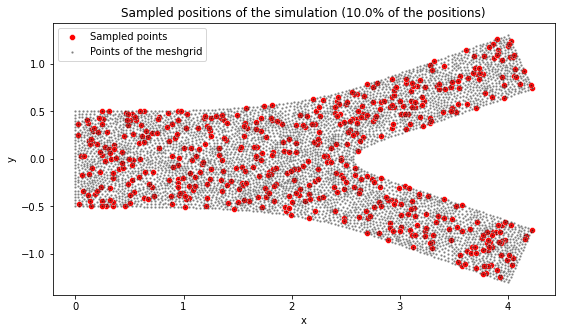

In [78]:
plot_sampled_coord(new_inds) 

Let's flatten our matrices into a single matrix with dimensions $(N_s, (2 N_u N_t))$. For each simulation, the x and y speed coordinates are compressed to the following 1D matrix:

$$
\mathbf{M_{1D}}
=
\begin{bmatrix}
\vdots \\
u_{x}^{(0)} \\
\vdots \\
u_{y}^{(0)} \\
\vdots \\
u_{x}^{(1)} \\
\vdots \\
u_{y}^{(1)} \\
\vdots \\
u_{x}^{(N_t - 1)} \\
\vdots \\
u_{y}^{(N_t - 1)} \\
\vdots 
\end{bmatrix}
$$



In [80]:
flattened_array = flatten(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 60500)

Let's make a sanity check that the dimension of 1 datapoint is indeed ${2 * new_{N_t} * new_{N_u}}$.

In [81]:
assert flattened_array.shape[1] == 2*new_Nt*new_Nu

print(2*new_Nt*new_Nu)

60500


## 3. Pickle  <a name="pickle"></a>

To avoid the loading and processing steps each time we open the notebook, we will save the processed matrix "flattened_array" using pickle. 

In the following cell, we will create pickles for every subsampled data according to the ratios_pts and the ratios_t.

In [14]:
'''
ratios_pts = [0.1, 0.05, 0.02]
ratios_t = [0.5, 0.25, 0.1]

create_subsamples(Ux, Uy, ratios_pts, ratios_t, name_file='middle_small')
'''

The cell above is only intented to be run __once__.

#### Start from here if you the pickle file already exist in your data folder <a name="start_pickle"></a>

Change only the following cell to change the name of the file you want to open.

In [3]:
ratios = [0.1, 0.5]
size = ['very_small', 'middle_small', 'small']

name = 'processed_'+str(size[1])+'_'+str(ratios[0])+'_'+str(ratios[1])

print('name of the file you want to read:', name)

name of the file you want to read: processed_middle_small_0.1_0.5


In [4]:
flattened_array  = cPickle.load(open("data/pickle/"+str(size[1])+"/"+name, "rb"))

In [6]:
print(flattened_array)

[[ 6.59818698e-02  1.82234920e-02  6.44159502e-02 ...  1.03034493e+00
  -9.73947264e-03 -1.67477632e-02]
 [ 5.29771523e-02  1.32216300e-02  4.90189335e-02 ...  9.93200215e-01
   5.02639122e-03  1.41599883e-03]
 [ 8.25671280e-02  2.32952726e-02  6.87771891e-02 ...  1.77500861e+00
   3.44533164e-04  1.81417079e-02]
 ...
 [ 2.19606656e-01  2.55903473e-02  2.29397872e-01 ...  1.46759534e+00
   7.42708226e-02 -1.34336791e-02]
 [ 2.41341112e-01  5.06083120e-02  2.15209040e-01 ...  4.44840207e+00
   4.35858394e-02  2.36892166e-02]
 [ 6.98710694e-02  1.96083000e-02  6.43463295e-02 ...  1.38366628e+00
  -1.23426650e-03  1.73919218e-03]]


##### Final step : split train/test

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [7]:
x_train, x_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = x_train, x_test

print(x_train.shape)
print(x_test.shape)

(157, 60500)
(18, 60500)


## 4. Feed-forward auto-encoder  <a name="autoencoder"></a>

Let's have a first look at our model.

--------------------------------
FOLD 0
--------------------------------
Epoch:1/50 Training Error:0.996 Test Error:0.996
Epoch:2/50 Training Error:0.964 Test Error:0.963
Epoch:3/50 Training Error:0.858 Test Error:0.854
Epoch:4/50 Training Error:0.678 Test Error:0.671
Epoch:5/50 Training Error:0.470 Test Error:0.459
Epoch:6/50 Training Error:0.293 Test Error:0.281
Epoch:7/50 Training Error:0.176 Test Error:0.164
Epoch:8/50 Training Error:0.116 Test Error:0.107
Epoch:9/50 Training Error:0.093 Test Error:0.085
Epoch:10/50 Training Error:0.088 Test Error:0.075
Epoch:11/50 Training Error:0.086 Test Error:0.070
Epoch:12/50 Training Error:0.085 Test Error:0.068
Epoch:13/50 Training Error:0.084 Test Error:0.067
Epoch:14/50 Training Error:0.084 Test Error:0.066
Epoch:15/50 Training Error:0.084 Test Error:0.065
Epoch:16/50 Training Error:0.083 Test Error:0.065
Epoch:17/50 Training Error:0.083 Test Error:0.065
Epoch:18/50 Training Error:0.083 Test Error:0.065
Epoch:19/50 Training Error:0.083 Tes

Epoch:10/50 Training Error:0.071 Test Error:0.129
Epoch:11/50 Training Error:0.071 Test Error:0.128
Epoch:12/50 Training Error:0.070 Test Error:0.128
Epoch:13/50 Training Error:0.070 Test Error:0.128
Epoch:14/50 Training Error:0.070 Test Error:0.128
Epoch:15/50 Training Error:0.070 Test Error:0.128
Epoch:16/50 Training Error:0.070 Test Error:0.128
Epoch:17/50 Training Error:0.070 Test Error:0.128
Epoch:18/50 Training Error:0.070 Test Error:0.128
Epoch:19/50 Training Error:0.070 Test Error:0.128
Epoch:20/50 Training Error:0.070 Test Error:0.128
Epoch:21/50 Training Error:0.070 Test Error:0.128
Epoch:22/50 Training Error:0.070 Test Error:0.128
Epoch:23/50 Training Error:0.070 Test Error:0.128
Epoch:24/50 Training Error:0.070 Test Error:0.128
Epoch:25/50 Training Error:0.070 Test Error:0.127
Epoch:26/50 Training Error:0.069 Test Error:0.127
Epoch:27/50 Training Error:0.069 Test Error:0.126
Epoch:28/50 Training Error:0.069 Test Error:0.126
Epoch:29/50 Training Error:0.068 Test Error:0.125


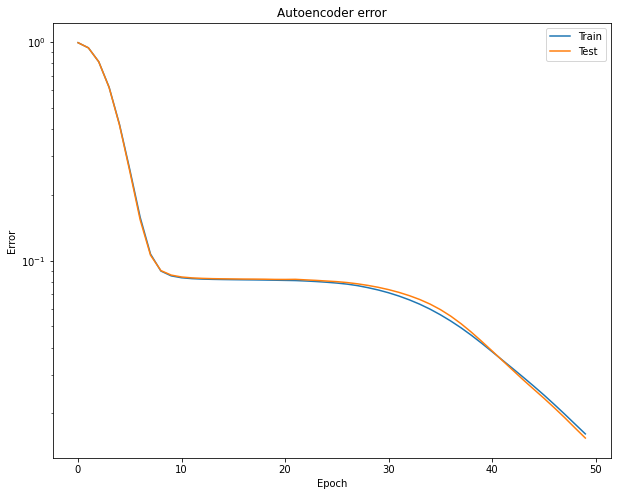

0.01542405583583156

In [8]:
learningRate = 1e-4
epochs= 50
input_size=x_train.shape[1]
k_folds = 5
criterion = nn.MSELoss()  
dataset_name = "middle_small" #Only used to save the plot with the good name
Kfold(x_train, k_folds, input_size, epochs, criterion, learningRate, neuron=5, momentum=0.9, comment = True)

#### Parameters tuning

Find the best learning rate of our model using cross-validation.

In [23]:
# define network parameters
learning_rates =[1e-3, 1e-4, 1e-5, 1e-6]
epochs= 50
input_size=x_train.shape[1]
k_folds = 5
dataset_name = "middle_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Learning rate =  0.001

Performance of 5 fold cross validation: 
Average Training Error: 0.011 	 Average Test Error: 0.013
 
Learning rate =  0.0001

Performance of 5 fold cross validation: 
Average Training Error: 0.011 	 Average Test Error: 0.011
 
Learning rate =  1e-05

Performance of 5 fold cross validation: 
Average Training Error: 0.105 	 Average Test Error: 0.104
 
Learning rate =  1e-06

Performance of 5 fold cross validation: 
Average Training Error: 0.978 	 Average Test Error: 0.978
 

Best learning rate is  0.0001  with a best error of :  0.011392209873615052



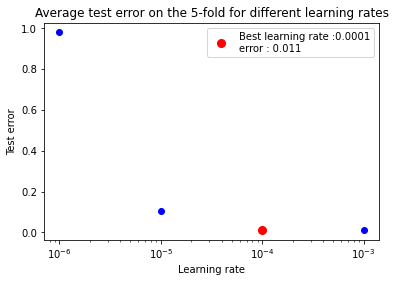

In [24]:
best_result, best_lr = tuning_lr(x_train, k_folds, input_size, epochs, criterion, learning_rates,  dataset_name_=dataset_name)

Find the best number of neurons in the latent space (neurons in the "middle layer of the auto-encoder") in the auto-encoder (which is actually the dimension of the compressed data).

In [25]:
# define network parameters
lr = best_lr # from above
epochs= 50
input_size=x_train.shape[1]
k_folds = 5
number_neurons = [3, 4, 5, 6, 7, 8, 9, 10]
dataset_name = "middle_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Number of neurons =  3

Performance of 5 fold cross validation: 
Average Training Error: 0.011 	 Average Test Error: 0.011
 
Number of neurons =  4

Performance of 5 fold cross validation: 
Average Training Error: 0.011 	 Average Test Error: 0.012
 
Number of neurons =  5

Performance of 5 fold cross validation: 
Average Training Error: 0.011 	 Average Test Error: 0.011
 
Number of neurons =  6

Performance of 5 fold cross validation: 
Average Training Error: 0.011 	 Average Test Error: 0.011
 
Number of neurons =  7

Performance of 5 fold cross validation: 
Average Training Error: 0.011 	 Average Test Error: 0.011
 
Number of neurons =  8

Performance of 5 fold cross validation: 
Average Training Error: 0.011 	 Average Test Error: 0.011
 
Number of neurons =  9

Performance of 5 fold cross validation: 
Average Training Error: 0.011 	 Average Test Error: 0.011
 
Number of neurons =  10

Performance of 5 fold cross validation: 
Average Training Error: 0.010 	 Average Test Error: 0.011
 

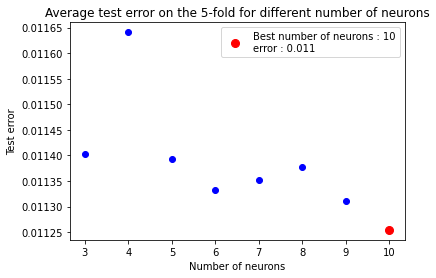

In [26]:
best_result, best_neurons_nb = tuning_latent_layer(x_train, k_folds, input_size, epochs, criterion, lr, number_neurons,  dataset_name_=dataset_name)

#### Let's try with the tuned parameters and see how it goes along the epochs

In [27]:
# define network parameters
learningRate= best_lr
epochs=50
input_size=x_train.shape[1]
k_folds = 5
neuron_ = best_neurons_nb

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

--------------------------------
FOLD 0
--------------------------------
Epoch:1/50 Training Error:0.980 Test Error:0.980
Epoch:2/50 Training Error:0.893 Test Error:0.891
Epoch:3/50 Training Error:0.737 Test Error:0.732
Epoch:4/50 Training Error:0.539 Test Error:0.531
Epoch:5/50 Training Error:0.355 Test Error:0.344
Epoch:6/50 Training Error:0.218 Test Error:0.207
Epoch:7/50 Training Error:0.136 Test Error:0.127
Epoch:8/50 Training Error:0.100 Test Error:0.093
Epoch:9/50 Training Error:0.090 Test Error:0.078
Epoch:10/50 Training Error:0.087 Test Error:0.072
Epoch:11/50 Training Error:0.085 Test Error:0.068
Epoch:12/50 Training Error:0.085 Test Error:0.067
Epoch:13/50 Training Error:0.084 Test Error:0.066
Epoch:14/50 Training Error:0.084 Test Error:0.065
Epoch:15/50 Training Error:0.084 Test Error:0.065
Epoch:16/50 Training Error:0.084 Test Error:0.065
Epoch:17/50 Training Error:0.084 Test Error:0.065
Epoch:18/50 Training Error:0.084 Test Error:0.065
Epoch:19/50 Training Error:0.084 Tes

Epoch:10/50 Training Error:0.071 Test Error:0.129
Epoch:11/50 Training Error:0.071 Test Error:0.128
Epoch:12/50 Training Error:0.070 Test Error:0.128
Epoch:13/50 Training Error:0.070 Test Error:0.128
Epoch:14/50 Training Error:0.070 Test Error:0.128
Epoch:15/50 Training Error:0.070 Test Error:0.128
Epoch:16/50 Training Error:0.070 Test Error:0.128
Epoch:17/50 Training Error:0.070 Test Error:0.128
Epoch:18/50 Training Error:0.070 Test Error:0.128
Epoch:19/50 Training Error:0.070 Test Error:0.128
Epoch:20/50 Training Error:0.070 Test Error:0.127
Epoch:21/50 Training Error:0.069 Test Error:0.127
Epoch:22/50 Training Error:0.069 Test Error:0.127
Epoch:23/50 Training Error:0.069 Test Error:0.126
Epoch:24/50 Training Error:0.069 Test Error:0.126
Epoch:25/50 Training Error:0.068 Test Error:0.125
Epoch:26/50 Training Error:0.067 Test Error:0.124
Epoch:27/50 Training Error:0.066 Test Error:0.122
Epoch:28/50 Training Error:0.065 Test Error:0.119
Epoch:29/50 Training Error:0.063 Test Error:0.116


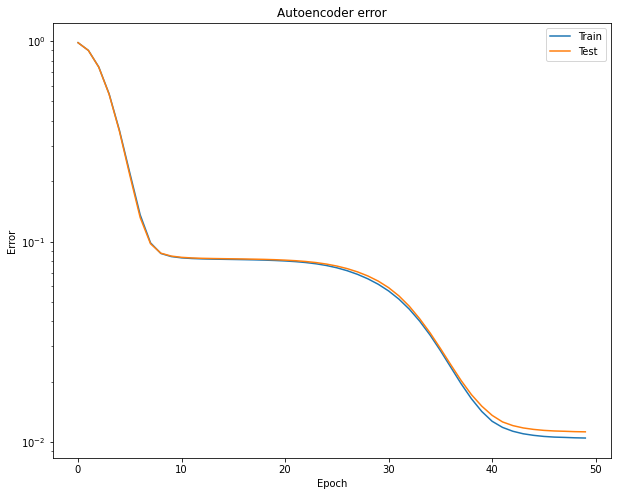

0.01125421934209768

In [28]:
Kfold(x_train, k_folds, input_size, epochs, criterion, learningRate, neuron=neuron_)

#### Quality of the compression on the test set using the tuned parameters

We will now train and test our auto-encoder for different sample size of our initial dataset. To do so we will do a batch processing and store the final train and test errors. See the report to see the nice comparison table.

In [29]:
import glob
import os 
import _pickle as cPickle

dataset = 'middle_small'
file_location = os.path.join('data', 'pickle', dataset, '*')
filenames = glob.glob(file_location)
i=0 


# define the parameters of the model
learningRate= best_lr
neuron_ = best_neurons_nb

epochs=50
criterion = nn.MSELoss() 

test_errors = []
train_errors = []
names = [] #Just to be sure of which error corresponds to which sub-dataset

for f in filenames:
    
    print("\033[1m" +'Train/Test of the sub-dataset ' + f + "\033[0m")
    
    #Load the data
    x  = cPickle.load(open(f, "rb"))
    
    #Split
    x_train, x_test = train_test_split(x, test_size=0.1, random_state=seed)
    y_train, y_test = x_train, x_test
    
    #Declare the model
    input_size=x_train.shape[1]
    model = Autoencoder(input_size, neuron_)
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=1e-5)
    
    #Dataloader
    train_loader = DataLoader(x_train)
    test_loader = DataLoader(x_test)
    
    #Training and testing over the epochs
    for epoch in range(epochs):
        # train the model 
        train_loss=train_epoch(train_loader, model, criterion, optimizer)
        # compute the relative training error
        train_error = valid_epoch(train_loader, model)
        # compute the relative test error
        test_error=valid_epoch(test_loader, model)
        
        print("Epoch:{}/{} Training Error:{:.3f} Test Error:{:.3f}".format(epoch + 1,epochs,train_error,test_error))
    
    #Save the last epoch train and test errors
    test_errors.append(test_error)
    train_errors.append(train_error)
    names.append(f)

Train/Test of the sub-dataset data/pickle/middle_small/processed_middle_small_0.02_0.5
Epoch:1/50 Training Error:0.076 Test Error:0.081
Epoch:2/50 Training Error:0.076 Test Error:0.081
Epoch:3/50 Training Error:0.076 Test Error:0.082
Epoch:4/50 Training Error:0.075 Test Error:0.081
Epoch:5/50 Training Error:0.037 Test Error:0.039
Epoch:6/50 Training Error:0.016 Test Error:0.016
Epoch:7/50 Training Error:0.015 Test Error:0.015
Epoch:8/50 Training Error:0.015 Test Error:0.015
Epoch:9/50 Training Error:0.015 Test Error:0.015
Epoch:10/50 Training Error:0.015 Test Error:0.015
Epoch:11/50 Training Error:0.015 Test Error:0.015
Epoch:12/50 Training Error:0.015 Test Error:0.015
Epoch:13/50 Training Error:0.015 Test Error:0.015
Epoch:14/50 Training Error:0.015 Test Error:0.015
Epoch:15/50 Training Error:0.017 Test Error:0.017
Epoch:16/50 Training Error:0.015 Test Error:0.015
Epoch:17/50 Training Error:0.015 Test Error:0.015
Epoch:18/50 Training Error:0.015 Test Error:0.015
Epoch:19/50 Training E

Epoch:8/50 Training Error:0.019 Test Error:0.019
Epoch:9/50 Training Error:0.016 Test Error:0.017
Epoch:10/50 Training Error:0.016 Test Error:0.017
Epoch:11/50 Training Error:0.016 Test Error:0.016
Epoch:12/50 Training Error:0.016 Test Error:0.017
Epoch:13/50 Training Error:0.016 Test Error:0.016
Epoch:14/50 Training Error:0.016 Test Error:0.017
Epoch:15/50 Training Error:0.016 Test Error:0.016
Epoch:16/50 Training Error:0.016 Test Error:0.017
Epoch:17/50 Training Error:0.016 Test Error:0.016
Epoch:18/50 Training Error:0.016 Test Error:0.016
Epoch:19/50 Training Error:0.016 Test Error:0.016
Epoch:20/50 Training Error:0.016 Test Error:0.017
Epoch:21/50 Training Error:0.016 Test Error:0.017
Epoch:22/50 Training Error:0.017 Test Error:0.018
Epoch:23/50 Training Error:0.034 Test Error:0.038
Epoch:24/50 Training Error:0.015 Test Error:0.016
Epoch:25/50 Training Error:0.015 Test Error:0.015
Epoch:26/50 Training Error:0.014 Test Error:0.014
Epoch:27/50 Training Error:0.013 Test Error:0.013
Ep

Epoch:17/50 Training Error:0.015 Test Error:0.015
Epoch:18/50 Training Error:0.015 Test Error:0.016
Epoch:19/50 Training Error:0.015 Test Error:0.015
Epoch:20/50 Training Error:0.015 Test Error:0.015
Epoch:21/50 Training Error:0.015 Test Error:0.015
Epoch:22/50 Training Error:0.014 Test Error:0.014
Epoch:23/50 Training Error:0.014 Test Error:0.014
Epoch:24/50 Training Error:0.014 Test Error:0.014
Epoch:25/50 Training Error:0.022 Test Error:0.024
Epoch:26/50 Training Error:0.015 Test Error:0.015
Epoch:27/50 Training Error:0.015 Test Error:0.015
Epoch:28/50 Training Error:0.015 Test Error:0.015
Epoch:29/50 Training Error:0.015 Test Error:0.015
Epoch:30/50 Training Error:0.015 Test Error:0.015
Epoch:31/50 Training Error:0.015 Test Error:0.015
Epoch:32/50 Training Error:0.015 Test Error:0.015
Epoch:33/50 Training Error:0.014 Test Error:0.014
Epoch:34/50 Training Error:0.014 Test Error:0.014
Epoch:35/50 Training Error:0.014 Test Error:0.014
Epoch:36/50 Training Error:0.015 Test Error:0.014


In [30]:
from pandas import *

#If you want to load the test and train errors from the saved pickles files, uncomment following lines :
'''
dataset = "middle_small"
train_errors  = cPickle.load(open("data/pickle/results/"+"train_errors_" + dataset, "rb"))
test_errors  = cPickle.load(open("data/pickle/results/"+"test_errors_" + dataset, "rb"))
'''

results = DataFrame({'' : ['50%', '25%', '10%'],
                   '10%' : test_errors[:3][::-1],
                   '5%' : test_errors[3:6][::-1],
                   '2%' : test_errors[6:9][::-1]})

results = results.set_index('')

display(results)
print("\033[1m" + 'Table of relative error depending on the sampling of the dataset' + "\033[0m")
print('x : sampling of times')
print('y : sampling of positions')

,10%,5%,2%
,,,
50%,0.004858,0.007889,0.008484
25%,0.005781,0.014525,0.007564
10%,0.006972,0.005566,0.007189


Table of relative error depending on the sampling of the dataset
x : sampling of times
y : sampling of positions


In [31]:
#Save in pickles
name = "train_errors_" + dataset
cPickle.dump( train_errors , open( name, "wb" ) )
name = "test_errors_" + dataset
cPickle.dump( test_errors , open( name, "wb" ) )

## 5. Physical interpretation <a name="physical"></a>

After compressing our data with the help of the feed-forward encoder, we can investigate if there exists a relationship between the latent neurons and the initial physical parameters.

##### Extract the output of the encoder (X_compressed)

In [17]:
import _pickle as cPickle

# define the parameters of the model
learningRate= 1e-4
neuron_ = 10
epochs=50
criterion = nn.MSELoss() 


#Load the data
x  = cPickle.load(open('data/pickle/middle_small/processed_middle_small_0.05_0.1', "rb"))

#Split
x_train, x_test = train_test_split(x, test_size=0.1, random_state=seed, shuffle=False)
y_train, y_test = x_train, x_test

#Declare the model
input_size=x_train.shape[1]
model = Autoencoder(input_size, neuron_)
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=1e-5)

#Dataloader
train_loader = DataLoader(x_train, batch_size=20)
test_loader = DataLoader(x_test, batch_size=20)

#Training and testing over the epochs
for epoch in range(epochs):
    # train the model 
    train_loss=train_epoch(train_loader, model, criterion, optimizer)
    # compute the relative training error
    train_error = valid_epoch(train_loader, model)
    # compute the relative test error
    test_error=valid_epoch(test_loader, model)

    print("Epoch:{}/{} Training Error:{:.3f} Test Error:{:.3f}".format(epoch + 1,epochs,train_error,test_error))

#Look at the compression
compressed_X_train = []
for train in train_loader :
    train = train.float()
    compressed_x_train = model.forward(x=train, show_compression=True)
    compressed_X_train.append(compressed_x_train.detach().numpy())

compressed_X_test = []    
for test in test_loader :
    test = test.float()
    compressed_x_test = model.forward(x=test, show_compression=True)
    compressed_X_test.append(compressed_x_test.detach().numpy())       

Epoch:1/50 Training Error:0.986 Test Error:0.986
Epoch:2/50 Training Error:0.896 Test Error:0.895
Epoch:3/50 Training Error:0.690 Test Error:0.687
Epoch:4/50 Training Error:0.460 Test Error:0.455
Epoch:5/50 Training Error:0.267 Test Error:0.260
Epoch:6/50 Training Error:0.145 Test Error:0.133
Epoch:7/50 Training Error:0.101 Test Error:0.072
Epoch:8/50 Training Error:0.093 Test Error:0.062
Epoch:9/50 Training Error:0.091 Test Error:0.060
Epoch:10/50 Training Error:0.091 Test Error:0.060
Epoch:11/50 Training Error:0.090 Test Error:0.060
Epoch:12/50 Training Error:0.090 Test Error:0.060
Epoch:13/50 Training Error:0.090 Test Error:0.059
Epoch:14/50 Training Error:0.090 Test Error:0.059
Epoch:15/50 Training Error:0.090 Test Error:0.059
Epoch:16/50 Training Error:0.089 Test Error:0.059
Epoch:17/50 Training Error:0.089 Test Error:0.059
Epoch:18/50 Training Error:0.088 Test Error:0.058
Epoch:19/50 Training Error:0.087 Test Error:0.058
Epoch:20/50 Training Error:0.086 Test Error:0.056
Epoch:21/

In [18]:
comp_X_train = np.concatenate(np.squeeze(np.array(compressed_X_train)))
comp_X_test = (np.squeeze(np.array(compressed_X_test)))

In [19]:
print(comp_X_train.shape)
print(comp_X_test.shape)

(157, 10)
(18, 10)


##### Correlation between the neurons

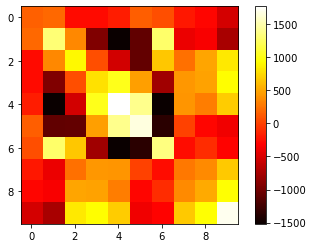

In [20]:
import seaborn as sns

corr = np.cov(comp_X_train.T)

# plot the heatmap
plt.imshow(corr,cmap='hot',interpolation='nearest')
plt.colorbar()
plt.show()

##### Load the real parameters that generated the solutions of the heamodynamic equation

In [21]:
compressed_Y_pd = pd.read_csv("Data/params_middle_small.csv.bz2", header=None)
comp_Y = compressed_Y_pd.to_numpy()

In [22]:
comp_Y.shape

(175, 5)

In [23]:
comp_Y_train, comp_Y_test = train_test_split(comp_Y, test_size=0.1, random_state=seed, shuffle=False)
comp_Y_test.shape

(18, 5)

##### Regression model

Feature engineering : Polynomial extension 

In [24]:
exponents = np.arange(3) + 1

comp_X_train_pol = []
for row in comp_X_train: 
    comp_X_train_pol.append((row**exponents[:,None]).ravel())
    
comp_X_test_pol = []
for row in comp_X_test: 
    comp_X_test_pol.append((row**exponents[:,None]).ravel())    

In [25]:
from sklearn.linear_model import LinearRegression
reg_pol = LinearRegression().fit(comp_X_train, comp_Y_train)
train_score = (reg_pol.score(comp_X_train, comp_Y_train))
test_score = (reg_pol.score(comp_X_test, comp_Y_test))
print('The train score is: ', train_score)
print('The test score is: ', test_score)

The train score is:  0.7306589293686274
The test score is:  0.61655966119606


In [26]:
from sklearn.linear_model import Ridge
ridge_pol = Ridge(alpha=1).fit(comp_X_train_pol, comp_Y_train)
train_score_ridge = (ridge_pol.score(comp_X_train_pol, comp_Y_train))
test_score_ridge = (ridge_pol.score(comp_X_test_pol, comp_Y_test))
print('The train score is: ', train_score_ridge)
print('The test score is: ', test_score_ridge)

The train score is:  0.7647312581330641
The test score is:  0.5016827199070589


In [27]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=0, alpha=1).fit(comp_X_train, comp_Y_train)
train_score_elast = (regr.score(comp_X_train, comp_Y_train))
test_score_elast = (regr.score(comp_X_test, comp_Y_test))
print('The train score is: ', train_score_elast)
print('The test score is: ', test_score_elast)

The train score is:  0.29531717612058317
The test score is:  0.2865523471391199


##### Let's look at the quality of the fit in function of how trained the auto-encoder is (which means in function of the number of epochs)

In [31]:
epochs_ =100

test_scores, test_scores_ridge, test_scores_elasticNet, train_scores, train_scores_ridge, train_scores_elasticNet = physical_params_pipeline(dataset_name= 'data/pickle/middle_small/processed_middle_small_0.1_0.25', 
                                                                                            params_name= "Data/params_middle_small.csv.bz2", epochs=epochs_, degree=3, 
                                                                                            alpha_=1, seed=seed)


Epoch:1/100 Training Error:0.983 Test Error:0.983

For the simple regression model : 
The train score is:  0.6971841793445945
The test score is:  0.5551696035895681
For the Ridge regression model : 
The train score is:  0.6879834796380452
The test score is:  0.4835111061411091
For the ElasticNet regression model : 
The train score is:  0.2388882563358247
The test score is:  0.2681463134061471


Epoch:2/100 Training Error:0.882 Test Error:0.881

For the simple regression model : 
The train score is:  0.6935813821988462
The test score is:  0.5735482500957703
For the Ridge regression model : 
The train score is:  0.7550443948233699
The test score is:  0.5631137829711677
For the ElasticNet regression model : 
The train score is:  0.2838896058906485
The test score is:  0.28591500031721145


Epoch:3/100 Training Error:0.687 Test Error:0.685

For the simple regression model : 
The train score is:  0.6967309010765852
The test score is:  0.5829471990971227
For the Ridge regression model : 
The


Epoch:20/100 Training Error:0.080 Test Error:0.053

For the simple regression model : 
The train score is:  0.7406241966036723
The test score is:  0.5717176513073169
For the Ridge regression model : 
The train score is:  0.8077718268410397
The test score is:  0.6433595656745335
For the ElasticNet regression model : 
The train score is:  0.2949658953400293
The test score is:  0.28661513601898714


Epoch:21/100 Training Error:0.076 Test Error:0.050

For the simple regression model : 
The train score is:  0.742317360599125
The test score is:  0.5743143307789065
For the Ridge regression model : 
The train score is:  0.8069847893214275
The test score is:  0.6317669600264256
For the ElasticNet regression model : 
The train score is:  0.2949829496077383
The test score is:  0.28667787480156476


Epoch:22/100 Training Error:0.070 Test Error:0.046

For the simple regression model : 
The train score is:  0.7437450491291996
The test score is:  0.5784095962975082
For the Ridge regression model : 



Epoch:40/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7516380116139465
The test score is:  0.6231763793877831
For the Ridge regression model : 
The train score is:  0.8209071993582568
The test score is:  0.6576394101683288
For the ElasticNet regression model : 
The train score is:  0.29611035601021285
The test score is:  0.287824237861356


Epoch:41/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.751810551810811
The test score is:  0.624244219382609
For the Ridge regression model : 
The train score is:  0.8214482531892223
The test score is:  0.6572194414988346
For the ElasticNet regression model : 
The train score is:  0.2961463681488853
The test score is:  0.28785598267524876


Epoch:42/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7518236855762936
The test score is:  0.6249211572583805
For the Ridge regression model : 
Th


Epoch:59/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7536788789938279
The test score is:  0.6239527067144452
For the Ridge regression model : 
The train score is:  0.8339851290186436
The test score is:  0.676808470922217
For the ElasticNet regression model : 
The train score is:  0.2965254529733995
The test score is:  0.2880009222066435


Epoch:60/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7534833428447042
The test score is:  0.6224489585272215
For the Ridge regression model : 
The train score is:  0.8336459462258011
The test score is:  0.6740901934932353
For the ElasticNet regression model : 
The train score is:  0.2966319106034922
The test score is:  0.2880878104230717


Epoch:61/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7530306495090328
The test score is:  0.6221518541803863
For the Ridge regression model : 
Th


Epoch:78/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7502611879440505
The test score is:  0.6160707612918641
For the Ridge regression model : 
The train score is:  0.8441538452915778
The test score is:  0.7118540208657956
For the ElasticNet regression model : 
The train score is:  0.2967616400885593
The test score is:  0.2882651261157106


Epoch:79/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7502612562907031
The test score is:  0.6160782412704184
For the Ridge regression model : 
The train score is:  0.8447203366287523
The test score is:  0.7136477522643927
For the ElasticNet regression model : 
The train score is:  0.29674681361801064
The test score is:  0.2882693162662623


Epoch:80/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7502698286132841
The test score is:  0.6162443386540482
For the Ridge regression model : 



Epoch:97/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7496548648650594
The test score is:  0.6170265628531595
For the Ridge regression model : 
The train score is:  0.8488795846684637
The test score is:  0.7233748087291068
For the ElasticNet regression model : 
The train score is:  0.2971422096168991
The test score is:  0.28861312837317354


Epoch:98/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7496037120620598
The test score is:  0.6174545089672219
For the Ridge regression model : 
The train score is:  0.8490524250699882
The test score is:  0.7229852172105284
For the ElasticNet regression model : 
The train score is:  0.29716712289462005
The test score is:  0.2886550551866174


Epoch:99/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7496131284499365
The test score is:  0.6173710600640715
For the Ridge regression model : 

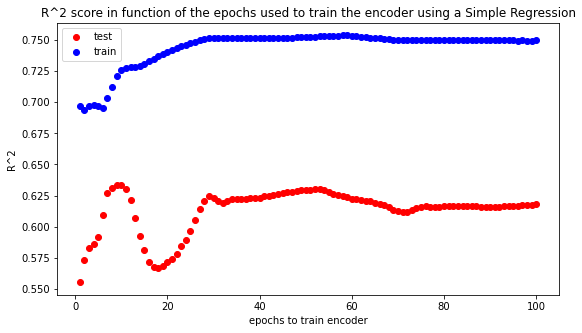

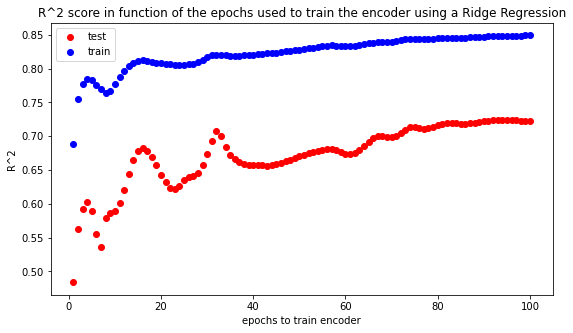

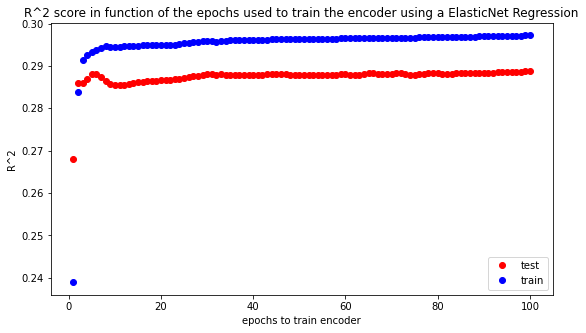

In [33]:
plot_regression_epochs(epochs_, test_scores, train_scores, method_name='Simple Regression') 
plot_regression_epochs(epochs_, test_scores_ridge, train_scores_ridge, method_name='Ridge Regression')
plot_regression_epochs(epochs_, test_scores_elasticNet, train_scores_elasticNet, method_name='ElasticNet Regression')

##### We can finally see how good the fit is in function of the subsampling

In [33]:
#We use the best model above, so it seems to be the ridge regression when we run for many epochs

epochs = 80

test_scores, train_scores, _ = pipeline_ParametersQuality_subsample(dataset_name= 'middle_small', 
                                            params_name= "Data/params_middle_small.csv.bz2", epochs=epochs, seed=seed) 

Train/Test of the sub-dataset data/pickle/middle_small/processed_middle_small_0.02_0.5
Epoch:80/80 Training Error:0.010 Test Error:0.013
The train score is:  0.8553241713546031
The test score is:  0.4059625481735358
Train/Test of the sub-dataset data/pickle/middle_small/processed_middle_small_0.05_0.5
Epoch:80/80 Training Error:0.007 Test Error:0.009
The train score is:  0.871331328005868
The test score is:  0.5705574781409073
Train/Test of the sub-dataset data/pickle/middle_small/processed_middle_small_0.1_0.25
Epoch:80/80 Training Error:0.004 Test Error:0.006
The train score is:  0.8647680905953508
The test score is:  0.01957181506888741
Train/Test of the sub-dataset data/pickle/middle_small/processed_middle_small_0.1_0.5
Epoch:80/80 Training Error:0.003 Test Error:0.005
The train score is:  0.8750230625168726
The test score is:  0.6512490270406732
Train/Test of the sub-dataset data/pickle/middle_small/processed_middle_small_0.02_0.1
Epoch:80/80 Training Error:0.014 Test Error:0.014


In [34]:
from pandas import *

results = DataFrame({'' : ['50%', '25%', '10%'],
                   '10%' : test_scores[:3][::-1],
                   '5%' : test_scores[3:6][::-1],
                   '2%' : test_scores[6:9][::-1]})

results = results.set_index('')

display(results)
print("\033[1m" + 'Table of fitting scores (R^2) depending on the sampling of the dataset' + "\033[0m")
print('x : sampling of times')
print('y : sampling of positions')

,10%,5%,2%
,,,
50%,0.019572,0.630822,0.329318
25%,0.570557,0.482461,0.604911
10%,0.405963,0.651249,0.508477


Table of fitting scores (R^2) depending on the sampling of the dataset
x : sampling of times
y : sampling of positions
